## Explore the columns with a lot of words in them to see what I want to use from them

In [63]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
%matplotlib notebook

In [77]:
# load the data
final_dir = r'/Users/ckrasnia/Documents/application_materials/rental_data'
data = pd.read_csv(os.path.join(final_dir,'raw_US_listings.csv'))


In [78]:
print(len(data))
data.keys()

498225


Index(['Unnamed: 0', 'id', 'listing_url', 'scrape_id', 'last_scraped', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm',

It looks like a lot of the text in the descriptions and titles includes some markdown formatting, like brakes and bold, I want to remove that, also make everything lower case before hand so that I am not getting duplicates with different cases

In [354]:
def remove_md(string):
    """
    function to remove angled brackets (< & >) and the markdown formatting inside them from strings. Should remove anything
    between two angled brackets, anything before a close bracket if there is only a close bracket, and anything after an 
    open bracket if there is only an open bracket
    
    Input : str
    output : str
    """
    # if both an open and close angle brackets are in the string
    if ('<' in string) and ('>' in string):
        open_brac = string.find('<')
        close_brac = string.find('>')
        # if there is something inside the brackets, drop that including the brackets
        if open_brac < close_brac:
            string = string.replace(string[open_brac : close_brac + 1],"")
        # if there isn't anything in between them, drop everything before and after
        else:
            string = string.replace(string[:close_brac+1],"")
            string = string.replace(string[open_brac:],"")
        # use recursion to fix any instances where there are multiple opens and closes
        return remove_md(string)
    elif ('<' in string):
        open_brac = string.find('<')
        string = string.replace(string[open_brac:],"")
        return remove_md(string)
    elif ('>' in string):
        close_brac = string.find('>')
        string = string.replace(string[:close_brac+1],"")
        return remove_md(string)
    else:
        return string

def drop_words(word_list):
    wl = list(word_list)
    stop_words = ['this', 'that','we', 'an','be', 'from', 'you', 'for', 'of', 'with', 'is', 'in', 'to', 'a','the',
                  'can','things','also', 'my','us', 'and', 'are', 'your', 'w/',
                  'has', 'on', 'have', 'or', '&', 'will', 'as', 'at', 'it', '-', 'so', '•', 'i', '+','eg', '|', '/']
    
    for sw in stop_words:
        if sw in wl:
            wl.remove(sw)
    return wl


def ordered_unique(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]


def get_dictionary(load=True, text=None, n_words=4000, overWrite=False, fileDir='/Users/ckrasnia/Documents/application_materials/rental_data/dictionary.pkl'):
    """
    Retrieves a dictionary of unnique words, where each word is a key and each key is assigned a unique integer. Default
    is to load a previously saved file, but to generate a new dictionary, set load=False and provide a text
    
    Input :
        load (bool) defaults to True, if the dictionary should be loade from fileDir
        text (list of strings) a list of strings from which to generate the dictionary
        n_words (int) number of words to include in the dictionary
        overWrite (bool) only applies if text is provided, determines if the dictionary should be saved
        fileDir (str) the file that contains the dictionary / where the dictionary will be saved if overWrite=True
        
    Returns : 
        a dictionary where there are n_words keys which are strings and the values are a unique integer assigned
        according to the frequency of the words with 1 = most frequent. 0 is reserved for words not in the dictionary
    """
    
    import pickle

    if text != None:
        print('creating new dictionary...')
        u,cts = np.unique(text, return_counts=True)
        words = list(u[np.argsort(cts)[-n_words:]])
        words.reverse()# reverse so that 1 is the most frequent word
        vals = np.arange(1,n_words+1) # reserve 0 for words that are not in the top 4000
        dictionary = {word:val for word, val in zip(words,vals)}
        
        if overWrite:
            f = open(fileDir,"wb")
            pickle.dump(dictionary,f)
            print('new dictionary saved to {}'.format(fileDir))
            f.close()
    elif load: # load file if thats what we want
        print('loading pregenerated dictionary')
        f = open(fileDir,"rb")
        dictionary = pickle.load(f)
        f.close()
      
    else:
        raise Exception('dictionary must either be loaded with load=True or created by providing a list of strings to the text argument')
        
    return dictionary


def preprocess_text(column : pd.Series):
    """
    written to clean up the text data to translate it into numerical values for input to a model.
    steps: 
    1. changes nan values to empty strings
    2. lowercases all text
    3. removes markdown formatting
    4. removes special characters
    5. splits into a list of words
    6. drops a list of stopwords to pare down to a set of only meaningful words
    7. stems words with the porter stemming algorithm to remove endings to reduce the number of unique words
    8. only keeps the unique words of the list, while preserving order
    
    Input:
        column (pd.Series) with each row containing a string containing with multiple words
        
    Output:
        (pd.Series) the cleaned column with a list of unique words in each row
    """
    column[column.isna()] = ''
    #look at the original distribution of how many words there are per description
    descript_words = data['description'].str.lower()

    # first start by getting rid of some ugly formatting that will increase unique words we need to encode

    descript_words = descript_words.apply(remove_md)
    #also going to want to remove some punctuation
    descript_words = descript_words.str.replace("[():!.,?]","")
    descript_words = descript_words.str.split()

    # get rid of meaningless stop words
    descript_words = descript_words.apply(drop_words)

    # lematize words so that to reduce unique words 
    # this is pretty time intensive due to the loop over the list within each of the nearly 500k rows
    descript_words = descript_words.map(lambda x: [porter.stem(y) for y in x])

    # now I want unique words within each description
    descript_words = descript_words.apply(ordered_unique)

    # sometimes stop-words reappear after lematization, so try dropping them again
    descript_words = descript_words.apply(drop_words)
    return descript_words


def translate(word_list, dictionary):
    """
    A lossy conversion of words to numbers or numbers back to words. if word_list contains strings, it will translate to
    using the dictionary, if it is ints, it will translate to strings using the reverse translation. For words that are
    not in the dictionary, it will be mapped to None. for the reverse translation, 0 gets mapped to None
    
    Input : 
        word_list (list of int or str) list that you want translated
        dictionary (dict with str as keys mapped to a unique int) used to translate between words and ints
        
    Returns :
        a translated version of the list, the same length as the input word_list
    """
    import numbers

    # catch if there is no description
    try:
        if len(word_list) == 0:
            translated = [None]

        
        # translate to integers
        elif type(word_list[0]) == str:
            translated = np.array([*map(dictionary.get, word_list)])
    #             translated[translated==None]=0

        # translate to strings
        elif np.any([isinstance(x, numbers.Number) for x in word_list]):
            inverse_dict = {v: k for k, v in dictionary.items()}
            translated = np.array([*map(inverse_dict.get, word_list)])
            
        # if a list of Nones, return self as thats the best translation we can do
        elif (np.all([x == None for x in word_list])):
            translated = word_list
            
    except TypeError: # catches the case that there is only a None
        translated = None
        
    return translated
    

In [ ]:
# dw2=descript_words.apply(translate,args=(dictionary,))
dw2.apply(translate,args=(dictionary,))


/Users/ckrasnia/opt/anaconda3/envs/ds_default/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


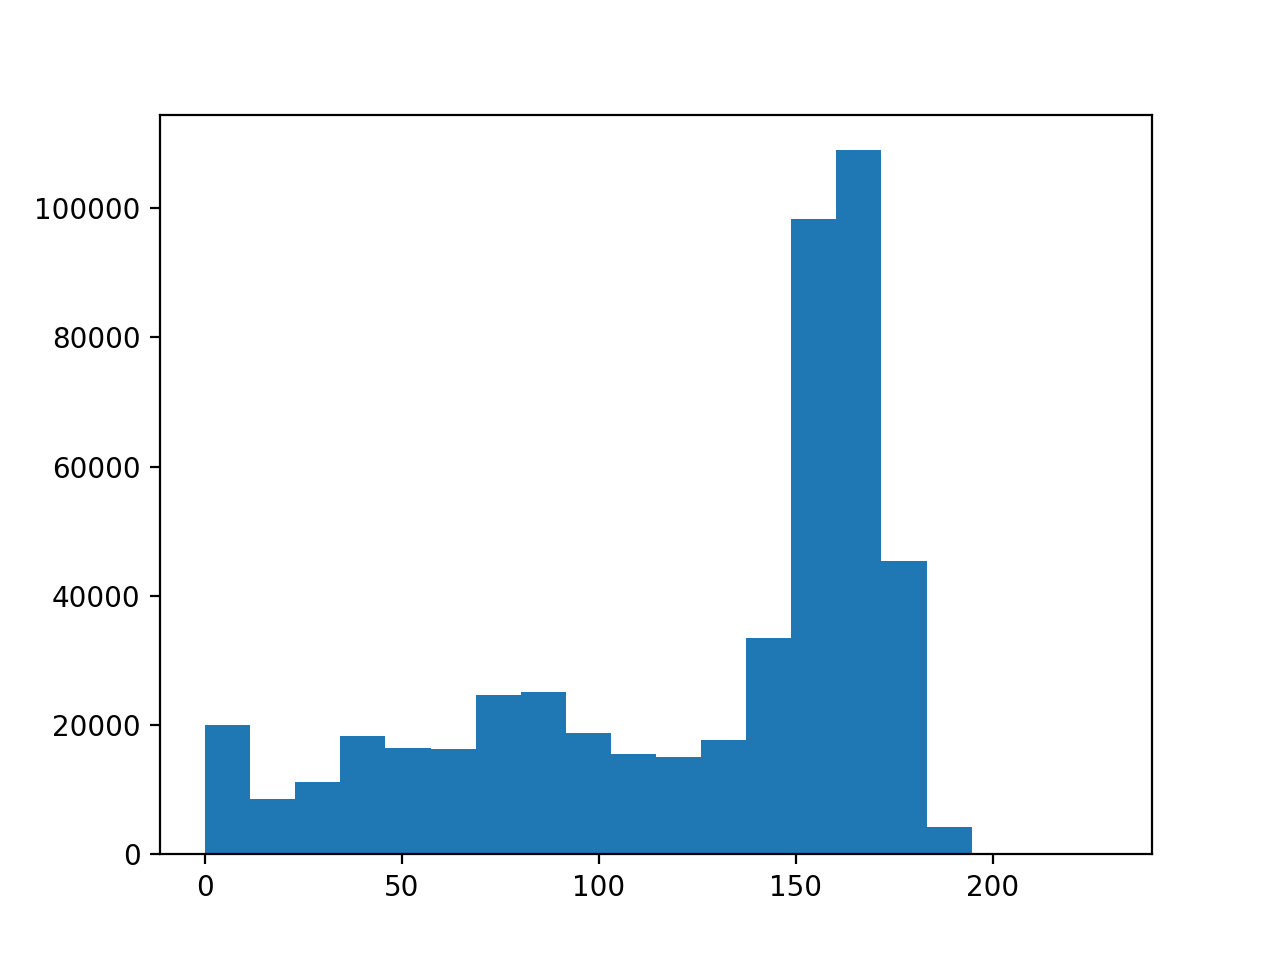

/Users/ckrasnia/opt/anaconda3/envs/ds_default/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: The default value of regex will change from True to False in a future version.
  app.launch_new_instance()


<IPython.core.display.Javascript object>


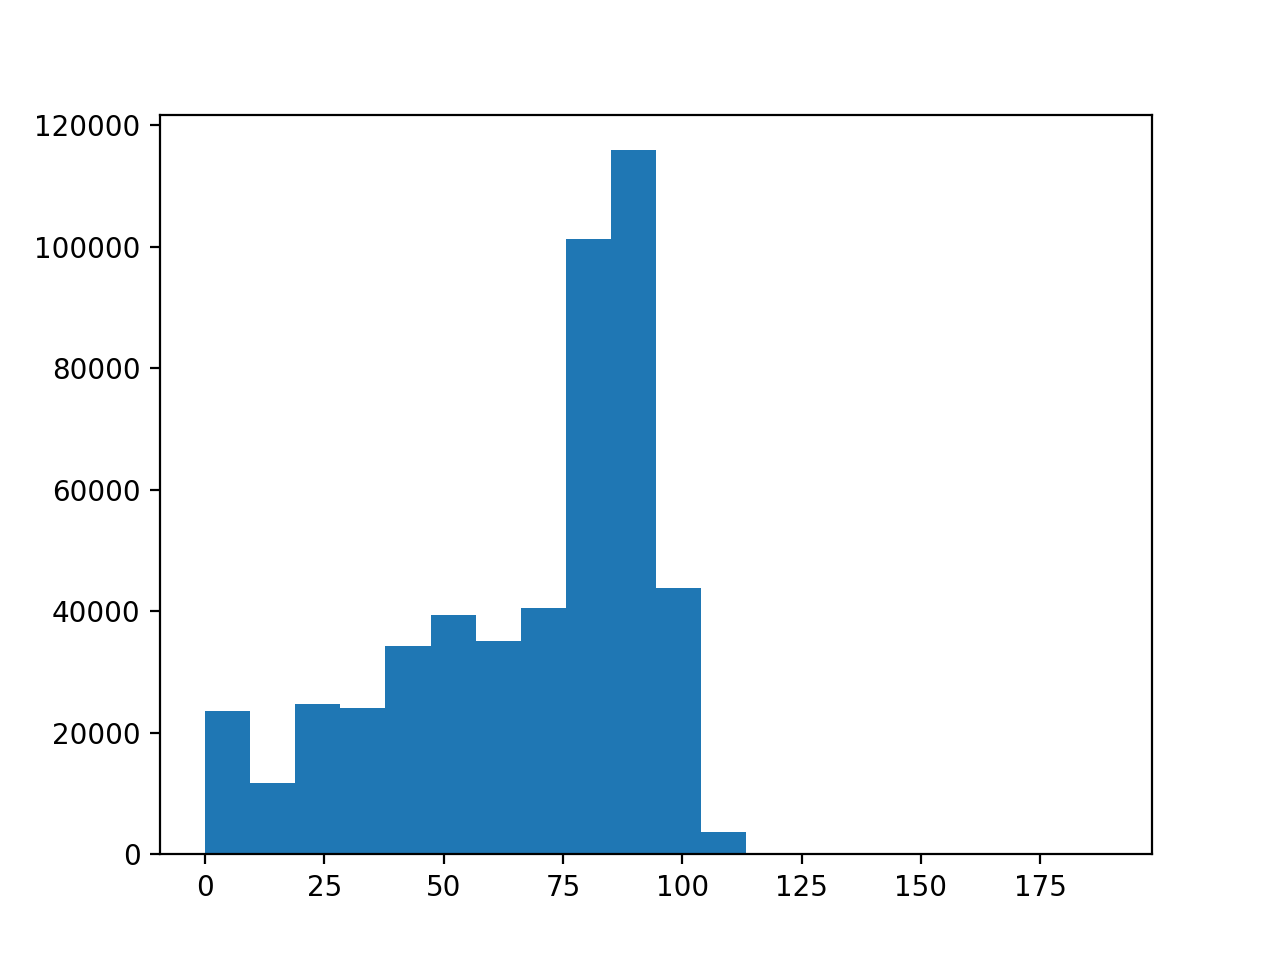

(array([2.35890e+04, 1.17490e+04, 2.46710e+04, 2.40460e+04, 3.43400e+04,
        3.94420e+04, 3.51210e+04, 4.06120e+04, 1.01212e+05, 1.15830e+05,
        4.38080e+04, 3.70200e+03, 5.70000e+01, 2.00000e+00, 4.10000e+01,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 3.00000e+00]),
 array([  0.  ,   9.45,  18.9 ,  28.35,  37.8 ,  47.25,  56.7 ,  66.15,
         75.6 ,  85.05,  94.5 , 103.95, 113.4 , 122.85, 132.3 , 141.75,
        151.2 , 160.65, 170.1 , 179.55, 189.  ]),
 <BarContainer object of 20 artists>)

In [253]:
# the description is probably going to be the most useful, just start by seeing how many words are usually in the descriptions
# going to make all lower case, remove common html/markdown formatting and split words on spaces 
# seems like some of the descriptions are probably NaN since I am getting a float error, so I'll change those to an empty string
data['description'][data['description'].isna()] = ''
og_first10 = data['description'].iloc[:10]
#look at the original distribution of how many words there are per description
descript_words = data['description'].str.lower()

plt.figure()
plt.hist(descript_words.str.split().apply(len), bins=20)

# first start by getting rid of some ugly formatting that will increase unique words we need to encode

descript_words = descript_words.apply(remove_md)
#also going to want to remove some punctuation
illegal_chars = "[.,]"
descript_words = descript_words.str.replace("[():!.,?]","")
descript_words = descript_words.str.split()

mid_first10 = descript_words.iloc[:10]

# get rid of meaningless stop words
descript_words = descript_words.apply(drop_words)

# lematize words so that to reduce unique words 
# this is pretty time intensive due to the loop over the list within each of the nearly 500k rows
descript_words = descript_words.map(lambda x: [porter.stem(y) for y in x])

# now I want unique words within each description
descript_words = descript_words.apply(ordered_unique)

# sometimes stop-words reappear after lematization, so try dropping them again
descript_words = descript_words.apply(drop_words)
# check again what the word count distribution is like after preprocessing
plt.figure()
plt.hist(descript_words.apply(len), bins=20)


In [247]:
# take a look at the words to make sure they seem fine at a few stages of processing
for i in range(10):
    print(og_first10[i])
    print(mid_first10[i])
    print(descript_words.iloc[i])
    print('\n')

Custom built Studio with exquisite design. Real hardwood floor.<br />Perfect for the professional on the road desiring a nice quiet place to call home.<br />Fully furnished:<br />Custom-built Corian kitchen, built-in curio cabinet for display, desk nook, marble bath floor, large mirror closet, TV, AC, heat, on-site laundry.<br />All linens, kitchen utensils, iron & ironing board. Dedicated parking and pool.<br /><br />Near Tesla and Google shuttle stops, 5 min. to Kaiser , easy access to 280, 20 min to Stanford, Google, etc.<br /><br /><b>The space</b><br />Description<br /><br />A favorite for international corporate assignees and Silicon Valley interns. <br />This is absolutely one of a kind - custom designed for the most discriminating taste. Newly Renovated Studio: Furnished unit with Deluxe Amenities, ideal for the short term home away from home, contract professionals or corporate assignments. TRULY turnkey unit, just bring yourself + luggage; superior price/performance over exte

Nice, it looks like this shortened the length of the descriptions considerably. This isn't quite ready to be input to a model though, there are about 23k listings that have fewer than 10 words in this paired-down description, and only a very few with more than 132 words. I should drop some words or the listings overall for those long descriptions

<IPython.core.display.Javascript object>


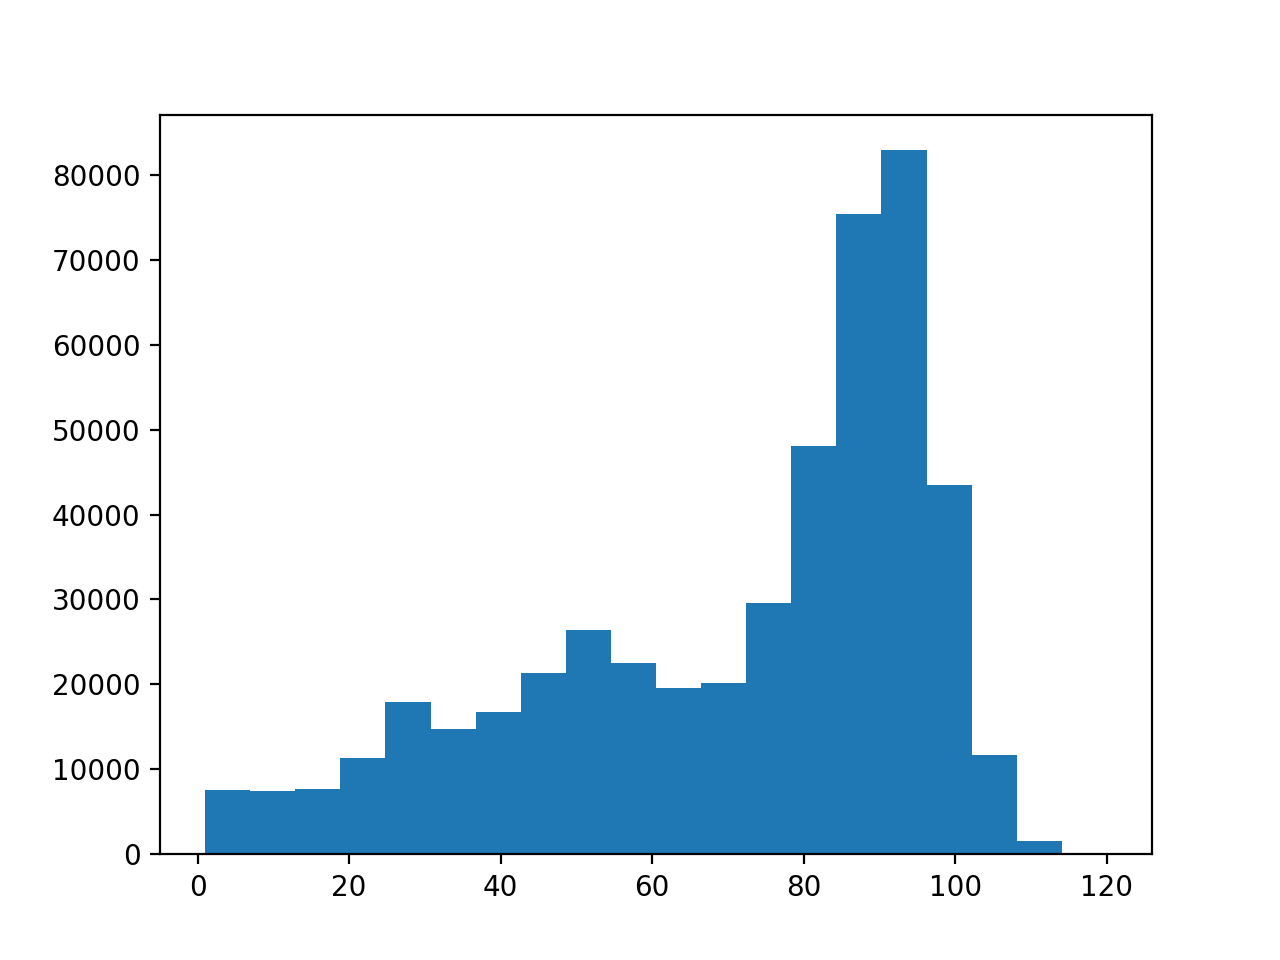

(array([ 7620.,  7467.,  7752., 11370., 17978., 14751., 16760., 21402.,
        26397., 22513., 19620., 20142., 29622., 48059., 75350., 82850.,
        43427., 11655.,  1557.,   119.]),
 array([  1.  ,   6.95,  12.9 ,  18.85,  24.8 ,  30.75,  36.7 ,  42.65,
         48.6 ,  54.55,  60.5 ,  66.45,  72.4 ,  78.35,  84.3 ,  90.25,
         96.2 , 102.15, 108.1 , 114.05, 120.  ]),
 <BarContainer object of 20 artists>)

In [231]:
plt.figure()
plt.hist(descript_words.apply(len), bins=20, range=[1,120])
# this seems like a more reasonable range of word numbers

In [248]:
# first get the words from a subset of the data into a single list
n=50000
idx=np.random.choice(np.arange(len(descript_words)),n)
dw_list = [w for j in descript_words.iloc[idx] for w in j]
u,cts = np.unique(dw_list, return_counts=True)

In [249]:
#see what the most common words are from this subset to find stop words to exclude 

u[np.argsort(cts)[-1000:]]


array(['going', 'entertaining', 'daily', 'head', 'traveler', 'wipe',
       'nature', 'gloves', 'notewe', 'hbo', 'starbucks', 'sunlight',
       'peace', 'feature', 'taking', 'having', 'shop', 'century',
       'maximum', 'asheville', 'portland', 'flooring', 'serene',
       'eclectic', 'setting', 'c', 'extremely', 'course', 'availability',
       'boston', 'should', 'real', 'arrive', 'hang', 'exclusive', 'trail',
       'spend', 'freeways', 'max', 'message', 'feeling', 'superior',
       'rules', 'different', 'however', 'transit', 'sits', 'step',
       'everyone', 'lights', 'facilities', 'high-end', 'mask', 'rail',
       'monthly', 'might', 'perfectly', 'layout', 'queen-sized', 'inch',
       'mountains', 'noteplease', 'sound', 'accessguest', 'international',
       'game', 'items', 'plush', 'toilet', 'national', 't', 'guidance',
       'streets', 'environment', 'golf', 'universal', 'site', 'using',
       'hall', 'washed', 'proximity', 'made', 'toiletries', 'gardens',
       'exper

In [250]:
# look at the distribution of word counts
np.sort(cts)[-4000:]/n*100
# with the top 1000 words, that gets down to an occurance rateof about 1% of listings having that word


array([ 0.144,  0.144,  0.144, ..., 37.064, 44.978, 46.094])

In [254]:
# ok I'm going to take the top 4000 words and give them numeric values, I can then assign each word to the numeric
# value so I can use that as input to a model
words = list(u[np.argsort(cts)[-4000:]])
words.reverse()# reverse so that 1 is the most frequent word
vals = np.arange(1,4000)

dictionary = {word:val for word, val in zip(words,vals)}



In [255]:
dictionary

{'kitchen': 1,
 'room': 2,
 'bedroom': 3,
 'all': 4,
 'home': 5,
 'private': 6,
 'living': 7,
 'located': 8,
 'bed': 9,
 'apartment': 10,
 'bathroom': 11,
 'space': 12,
 'restaurants': 13,
 '2': 14,
 'one': 15,
 'access': 16,
 'full': 17,
 'our': 18,
 'house': 19,
 'downtown': 20,
 'area': 21,
 'walk': 22,
 'new': 23,
 'tv': 24,
 'queen': 25,
 'just': 26,
 'stay': 27,
 'away': 28,
 'enjoy': 29,
 'large': 30,
 'parking': 31,
 'street': 32,
 'neighborhood': 33,
 'there': 34,
 'great': 35,
 'beautiful': 36,
 'two': 37,
 'close': 38,
 'floor': 39,
 '1': 40,
 'fully': 41,
 'guests': 42,
 'place': 43,
 'quiet': 44,
 'by': 45,
 'minutes': 46,
 'park': 47,
 'spacious': 48,
 'perfect': 49,
 'very': 50,
 'city': 51,
 'up': 52,
 'comfortable': 53,
 'coffee': 54,
 'modern': 55,
 'walking': 56,
 'location': 57,
 'if': 58,
 'not': 59,
 '3': 60,
 'dining': 61,
 'available': 62,
 'no': 63,
 'distance': 64,
 'only': 65,
 'out': 66,
 'heart': 67,
 'free': 68,
 'unit': 69,
 'bedrooms': 70,
 'cozy': 71,
 

In [257]:
# save this dictionary for future use
import pickle
f = open(os.path.join(final_dir,"dictionary.pkl"),"wb")

# save
pickle.dump(dictionary,f)

# close file
f.close()

In [99]:

"""Porter Stemming Algorithm
This is the Porter stemming algorithm, ported to Python from the
version coded up in ANSI C by the author. It may be be regarded
as canonical, in that it follows the algorithm presented in

Porter, 1980, An algorithm for suffix stripping, Program, Vol. 14,
no. 3, pp 130-137,

only differing from it at the points maked --DEPARTURE-- below.

See also http://www.tartarus.org/~martin/PorterStemmer

The algorithm as described in the paper could be exactly replicated
by adjusting the points of DEPARTURE, but this is barely necessary,
because (a) the points of DEPARTURE are definitely improvements, and
(b) no encoding of the Porter stemmer I have seen is anything like
as exact as this version, even with the points of DEPARTURE!

Vivake Gupta (v@nano.com)

Release 1: January 2001

Further adjustments by Santiago Bruno (bananabruno@gmail.com)
to allow word input not restricted to one word per line, leading
to:

release 2: July 2008

Modified by CSK to make it more user friendly for my purpose, changed the stem method
"""

import sys

class PorterStemmer:

    def __init__(self):
        """The main part of the stemming algorithm starts here.
        b is a buffer holding a word to be stemmed. The letters are in b[k0],
        b[k0+1] ... ending at b[k]. In fact k0 = 0 in this demo program. k is
        readjusted downwards as the stemming progresses. Zero termination is
        not in fact used in the algorithm.

        Note that only lower case sequences are stemmed. Forcing to lower case
        should be done before stem(...) is called.
        """

        self.b = ""  # buffer for word to be stemmed
        self.k = 0
        self.k0 = 0
        self.j = 0   # j is a general offset into the string

    def cons(self, i):
        """cons(i) is TRUE <=> b[i] is a consonant."""
        if self.b[i] == 'a' or self.b[i] == 'e' or self.b[i] == 'i' or self.b[i] == 'o' or self.b[i] == 'u':
            return 0
        if self.b[i] == 'y':
            if i == self.k0:
                return 1
            else:
                return (not self.cons(i - 1))
        return 1

    def m(self):
        """m() measures the number of consonant sequences between k0 and j.
        if c is a consonant sequence and v a vowel sequence, and <..>
        indicates arbitrary presence,

           <c><v>       gives 0
           <c>vc<v>     gives 1
           <c>vcvc<v>   gives 2
           <c>vcvcvc<v> gives 3
           ....
        """
        n = 0
        i = self.k0
        while 1:
            if i > self.j:
                return n
            if not self.cons(i):
                break
            i = i + 1
        i = i + 1
        while 1:
            while 1:
                if i > self.j:
                    return n
                if self.cons(i):
                    break
                i = i + 1
            i = i + 1
            n = n + 1
            while 1:
                if i > self.j:
                    return n
                if not self.cons(i):
                    break
                i = i + 1
            i = i + 1

    def vowelinstem(self):
        """vowelinstem() is TRUE <=> k0,...j contains a vowel"""
        for i in range(self.k0, self.j + 1):
            if not self.cons(i):
                return 1
        return 0

    def doublec(self, j):
        """doublec(j) is TRUE <=> j,(j-1) contain a double consonant."""
        if j < (self.k0 + 1):
            return 0
        if (self.b[j] != self.b[j-1]):
            return 0
        return self.cons(j)

    def cvc(self, i):
        """cvc(i) is TRUE <=> i-2,i-1,i has the form consonant - vowel - consonant
        and also if the second c is not w,x or y. this is used when trying to
        restore an e at the end of a short  e.g.

           cav(e), lov(e), hop(e), crim(e), but
           snow, box, tray.
        """
        if i < (self.k0 + 2) or not self.cons(i) or self.cons(i-1) or not self.cons(i-2):
            return 0
        ch = self.b[i]
        if ch == 'w' or ch == 'x' or ch == 'y':
            return 0
        return 1

    def ends(self, s):
        """ends(s) is TRUE <=> k0,...k ends with the string s."""
        length = len(s)
        if s[length - 1] != self.b[self.k]: # tiny speed-up
            return 0
        if length > (self.k - self.k0 + 1):
            return 0
        if self.b[self.k-length+1:self.k+1] != s:
            return 0
        self.j = self.k - length
        return 1

    def setto(self, s):
        """setto(s) sets (j+1),...k to the characters in the string s, readjusting k."""
        length = len(s)
        self.b = self.b[:self.j+1] + s + self.b[self.j+length+1:]
        self.k = self.j + length

    def r(self, s):
        """r(s) is used further down."""
        if self.m() > 0:
            self.setto(s)

    def step1ab(self):
        """step1ab() gets rid of plurals and -ed or -ing. e.g.

           caresses  ->  caress
           ponies    ->  poni
           ties      ->  ti
           caress    ->  caress
           cats      ->  cat

           feed      ->  feed
           agreed    ->  agree
           disabled  ->  disable

           matting   ->  mat
           mating    ->  mate
           meeting   ->  meet
           milling   ->  mill
           messing   ->  mess

           meetings  ->  meet
        """
        if self.b[self.k] == 's':
            if self.ends("sses"):
                self.k = self.k - 2
            elif self.ends("ies"):
                self.setto("i")
            elif self.b[self.k - 1] != 's':
                self.k = self.k - 1
        if self.ends("eed"):
            if self.m() > 0:
                self.k = self.k - 1
        elif (self.ends("ed") or self.ends("ing")) and self.vowelinstem():
            self.k = self.j
            if self.ends("at"):   self.setto("ate")
            elif self.ends("bl"): self.setto("ble")
            elif self.ends("iz"): self.setto("ize")
            elif self.doublec(self.k):
                self.k = self.k - 1
                ch = self.b[self.k]
                if ch == 'l' or ch == 's' or ch == 'z':
                    self.k = self.k + 1
            elif (self.m() == 1 and self.cvc(self.k)):
                self.setto("e")

    def step1c(self):
        """step1c() turns terminal y to i when there is another vowel in the stem."""
        if (self.ends("y") and self.vowelinstem()):
            self.b = self.b[:self.k] + 'i' + self.b[self.k+1:]

    def step2(self):
        """step2() maps double suffices to single ones.
        so -ization ( = -ize plus -ation) maps to -ize etc. note that the
        string before the suffix must give m() > 0.
        """
        if self.b[self.k - 1] == 'a':
            if self.ends("ational"):   self.r("ate")
            elif self.ends("tional"):  self.r("tion")
        elif self.b[self.k - 1] == 'c':
            if self.ends("enci"):      self.r("ence")
            elif self.ends("anci"):    self.r("ance")
        elif self.b[self.k - 1] == 'e':
            if self.ends("izer"):      self.r("ize")
        elif self.b[self.k - 1] == 'l':
            if self.ends("bli"):       self.r("ble") # --DEPARTURE--
            # To match the published algorithm, replace this phrase with
            #   if self.ends("abli"):      self.r("able")
            elif self.ends("alli"):    self.r("al")
            elif self.ends("entli"):   self.r("ent")
            elif self.ends("eli"):     self.r("e")
            elif self.ends("ousli"):   self.r("ous")
        elif self.b[self.k - 1] == 'o':
            if self.ends("ization"):   self.r("ize")
            elif self.ends("ation"):   self.r("ate")
            elif self.ends("ator"):    self.r("ate")
        elif self.b[self.k - 1] == 's':
            if self.ends("alism"):     self.r("al")
            elif self.ends("iveness"): self.r("ive")
            elif self.ends("fulness"): self.r("ful")
            elif self.ends("ousness"): self.r("ous")
        elif self.b[self.k - 1] == 't':
            if self.ends("aliti"):     self.r("al")
            elif self.ends("iviti"):   self.r("ive")
            elif self.ends("biliti"):  self.r("ble")
        elif self.b[self.k - 1] == 'g': # --DEPARTURE--
            if self.ends("logi"):      self.r("log")
        # To match the published algorithm, delete this phrase

    def step3(self):
        """step3() dels with -ic-, -full, -ness etc. similar strategy to step2."""
        if self.b[self.k] == 'e':
            if self.ends("icate"):     self.r("ic")
            elif self.ends("ative"):   self.r("")
            elif self.ends("alize"):   self.r("al")
        elif self.b[self.k] == 'i':
            if self.ends("iciti"):     self.r("ic")
        elif self.b[self.k] == 'l':
            if self.ends("ical"):      self.r("ic")
            elif self.ends("ful"):     self.r("")
        elif self.b[self.k] == 's':
            if self.ends("ness"):      self.r("")

    def step4(self):
        """step4() takes off -ant, -ence etc., in context <c>vcvc<v>."""
        if self.b[self.k - 1] == 'a':
            if self.ends("al"): pass
            else: return
        elif self.b[self.k - 1] == 'c':
            if self.ends("ance"): pass
            elif self.ends("ence"): pass
            else: return
        elif self.b[self.k - 1] == 'e':
            if self.ends("er"): pass
            else: return
        elif self.b[self.k - 1] == 'i':
            if self.ends("ic"): pass
            else: return
        elif self.b[self.k - 1] == 'l':
            if self.ends("able"): pass
            elif self.ends("ible"): pass
            else: return
        elif self.b[self.k - 1] == 'n':
            if self.ends("ant"): pass
            elif self.ends("ement"): pass
            elif self.ends("ment"): pass
            elif self.ends("ent"): pass
            else: return
        elif self.b[self.k - 1] == 'o':
            if self.ends("ion") and (self.b[self.j] == 's' or self.b[self.j] == 't'): pass
            elif self.ends("ou"): pass
            # takes care of -ous
            else: return
        elif self.b[self.k - 1] == 's':
            if self.ends("ism"): pass
            else: return
        elif self.b[self.k - 1] == 't':
            if self.ends("ate"): pass
            elif self.ends("iti"): pass
            else: return
        elif self.b[self.k - 1] == 'u':
            if self.ends("ous"): pass
            else: return
        elif self.b[self.k - 1] == 'v':
            if self.ends("ive"): pass
            else: return
        elif self.b[self.k - 1] == 'z':
            if self.ends("ize"): pass
            else: return
        else:
            return
        if self.m() > 1:
            self.k = self.j

    def step5(self):
        """step5() removes a final -e if m() > 1, and changes -ll to -l if
        m() > 1.
        """
        self.j = self.k
        if self.b[self.k] == 'e':
            a = self.m()
            if a > 1 or (a == 1 and not self.cvc(self.k-1)):
                self.k = self.k - 1
        if self.b[self.k] == 'l' and self.doublec(self.k) and self.m() > 1:
            self.k = self.k -1

    def stem(self, p, i=0, j=None):
        """In stem(p,i,j), p is a char pointer, and the string to be stemmed
        is from p[i] to p[j] inclusive. Typically i is zero and j is the
        offset to the last character of a string, (p[j+1] == '\0'). The
        stemmer adjusts the characters p[i] ... p[j] and returns the new
        end-point of the string, k. Stemming never increases word length, so
        i <= k <= j. To turn the stemmer into a module, declare 'stem' as
        extern, and delete the remainder of this file.
        """
        # copy the parameters into statics
        if j == None:
            j = len(p)-1
        self.b = p
        self.k = j
        self.k0 = i
        if self.k <= self.k0 + 1:
            return self.b # --DEPARTURE--

        # With this line, strings of length 1 or 2 don't go through the
        # stemming process, although no mention is made of this in the
        # published algorithm. Remove the line to match the published
        # algorithm.

        self.step1ab()
        self.step1c()
        self.step2()
        self.step3()
        self.step4()
        self.step5()
        return self.b[self.k0:self.k+1]




In [183]:
from tensorflow import keras
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(num_words=20000)

17473536/17464789 [==============================] - 2s 0us/step


In [185]:
x_train

array([list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]),
       list([1, 194, 1153, 194, 82